In [5]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shapely.geometry import shape, Point
from tqdm import tqdm
import warnings

# Пригнічуємо попередження Matplotlib
warnings.filterwarnings("ignore", category=UserWarning)

# ======================================================
# НАЛАШТУВАННЯ
# ======================================================
DATASET_PATH = '/home/yurii/Programming/Quantum_Test_Data' # Шлях до вашої папки train/val
PATCH_SIZE = 512 # Очікуваний розмір патча (500 було у старому коді, 512 у новому)
EXPECTED_CHANNELS = 6 # B4, B3, B2, B8, B11, NDVI
RGB_INDICES = [0, 1, 2] # Індекси B4, B3, B2 для відображення RGB

# ======================================================
# 1. ФУНКЦІЯ ПЕРЕВІРКИ
# ======================================================
def validate_dataset(root_path, patch_size, expected_channels, rgb_indices):
    """Перевіряє структуру, розміри файлів та гомографію."""
    
    validation_results = {
        'total_folders': 0,
        'missing_files': 0,
        'incorrect_shape': 0,
        'correct_homography': 0,
        'incorrect_homography': 0,
        'successful_validation': 0,
    }
    
    # Рекурсивний пошук папок з даними
    all_data_folders = []
    for root, dirs, files in os.walk(root_path):
        if 'homography.npy' in files and 'img1.npy' in files and 'metadata.json' in files:
            all_data_folders.append(root)

    print(f"🔎 Знайдено {len(all_data_folders)} папок для перевірки.")
    
    for folder_path in tqdm(all_data_folders, desc="Перевірка структури та даних"):
        validation_results['total_folders'] += 1
        
        # Перевірка наявності всіх файлів
        required_files = ['img1.npy', 'img2.npy', 'homography.npy', 'metadata.json']
        if not all(os.path.exists(os.path.join(folder_path, f)) for f in required_files):
            validation_results['missing_files'] += 1
            continue
            
        try:
            # 1. Перевірка розміру (Shape)
            img1 = np.load(os.path.join(folder_path, 'img1.npy'))
            img2 = np.load(os.path.join(folder_path, 'img2.npy'))
            
            expected_shape = (patch_size, patch_size, expected_channels)
            
            if img1.shape != expected_shape or img2.shape != expected_shape:
                validation_results['incorrect_shape'] += 1
                continue
                
            # 2. Перевірка Гомографії (H)
            homography = np.load(os.path.join(folder_path, 'homography.npy'))
            
            # LoFTR вимагає H (3x3)
            if homography.shape == (3, 3):
                # Очікуємо тотожну матрицю (H_GT = np.eye(3))
                if np.allclose(homography, np.eye(3)):
                    validation_results['correct_homography'] += 1
                else:
                    validation_results['incorrect_homography'] += 1
                    
            validation_results['successful_validation'] += 1
                
        except Exception as e:
            # print(f"Помилка читання файлів у {folder_path}: {e}")
            validation_results['missing_files'] += 1 # Вважаємо як пошкоджений файл
            
    print("\n--- Результати Перевірки Датасету ---")
    print(f"✅ Успішно перевірено папок: {validation_results['successful_validation']}")
    print(f"❌ Помилка розміру (Shape): {validation_results['incorrect_shape']}")
    print(f"❌ Невірний/відсутній файл: {validation_results['missing_files']}")
    print(f"✅ Гомографія: Тотожна (правильна): {validation_results['correct_homography']}")
    print(f"⚠️ Гомографія: Нетотожна (можлива помилка): {validation_results['incorrect_homography']}")
    print("-----------------------------------")
    
    return all_data_folders

# ======================================================
# 2. ФУНКЦІЯ ВІЗУАЛІЗАЦІЇ
# ======================================================

def visualize_patch_and_deforestation(folder_path, rgb_indices):
    """Відображає img1 та img2 з накладеною зоною вирубки."""
    
    print(f"\n🖼️ Візуалізація: {os.path.basename(folder_path)}")
    
    # 1. Завантаження даних
    try:
        img1 = np.load(os.path.join(folder_path, 'img1.npy'))
        img2 = np.load(os.path.join(folder_path, 'img2.npy'))
        
        with open(os.path.join(folder_path, 'metadata.json'), 'r') as f:
            metadata = json.load(f)
            
    except Exception as e:
        print(f"Помилка завантаження файлів: {e}")
        return

    # 2. Виділення RGB каналів для відображення
    # Якщо канали нормалізовані до [0, 1], вони готові
    img1_rgb = img1[:, :, rgb_indices]
    img2_rgb = img2[:, :, rgb_indices]

    # 3. Обробка геометрії (для відображення на патчі)
    # Оскільки ми центрували патч на центроїді, 
    # патч не має трансформації в метаданих. Ми знаємо, що:
    # Центроїд (X, Y) знаходиться приблизно в центрі патча (256, 256)
    
    # Отримуємо геометрію вирубки (MultiPolygon)
    defor_geometry_json = metadata['deforestation']['geometry']
    defor_shape = shape(defor_geometry_json)
    
    # Отримуємо координати центроїда з метаданих
    centroid_x_orig, centroid_y_orig = metadata['centroid']
    
    # !!! Важливо: Ця частина потребує знання трансформації патча для точного накладання,
    # але оскільки патч центрується, ми можемо відобразити лише ГЕОМЕТРІЮ ВИРУБКИ.
    # Найпростіший спосіб: знайти bounding box вирубки та відобразити його.
    
    # Для візуалізації зони вирубки на патчі потрібні: 
    # 1) трансформація з геокоординат до пікселів патча,
    # 2) початкова координата (top_left) патча.
    # Оскільки ці дані не зберігаються в metadata.json, ми можемо:
    # А) Припустити, що центроїд патча знаходиться в (PATCH_SIZE/2, PATCH_SIZE/2)
    # Б) Відобразити відносну геометрію.
    
    # Найкращий підхід: відобразити Bounding Box вирубки відносно центроїда
    
    minx, miny, maxx, maxy = defor_shape.bounds
    
    # Ми не можемо точно відобразити MultiPolygon без матриці трансформації
    # (яка була обчислена під час crop_patch_around_centroid), 
    # але ми можемо відобразити центроїд та Bounding Box:
    
    
    # 4. Візуалізація
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # --- Знімок 1 (Літо) ---
    ax = axes[0]
    ax.imshow(img1_rgb)
    ax.set_title(f"Знімок 1 (Літо: {metadata['date_img1']})")
    
    # Відображення центроїда (у пікселях патча: центр = 256, 256)
    # Оскільки патч центрований на центроїді, ми просто ставимо його в центр вікна
    ax.plot(patch_size // 2, patch_size // 2, 'go', markersize=8, label='Центроїд Вирубки')
    
    # Відображення Bounding Box (якщо є)
    # Ми не маємо піксельних координат Bounding Box, але можемо показати розмір вирубки
    
    ax.axis('off')

    # --- Знімок 2 (Інший Сезон) ---
    ax = axes[1]
    ax.imshow(img2_rgb)
    ax.set_title(f"Знімок 2 ({metadata['season_pair'].split('_')[1].capitalize()}: {metadata['date_img2']})")
    ax.plot(patch_size // 2, patch_size // 2, 'ro', markersize=8, label='Центроїд Вирубки')
    
    ax.axis('off')
    
    # Додаємо інформацію про гомографію
    homography = np.load(os.path.join(folder_path, 'homography.npy'))
    H_status = 'Тотожна (ОК)' if np.allclose(homography, np.eye(3)) else 'Нетотожна (⚠️)'
    
    fig.suptitle(f"Пара: {os.path.basename(folder_path)} | H: {H_status} | ID: {metadata['deforestation_id']}", fontsize=14)
    plt.show()

# ======================================================
# ЗАПУСК ПЕРЕВІРКИ
# ======================================================

# 1. Запуск перевірки цілісності датасету
data_folders_list = validate_dataset(DATASET_PATH, PATCH_SIZE, EXPECTED_CHANNELS, RGB_INDICES)

if data_folders_list:
    print("\n--- Демонстрація Візуалізації ---")
    
    # 2. Демонстрація 3 випадкових коректних патчів
    np.random.seed(42)
    # Фільтруємо папки, які пройшли перевірку розмірів
    
    sample_folders = np.random.choice(data_folders_list, size=min(3, len(data_folders_list)), replace=False)
    
    for folder in sample_folders:
        visualize_patch_and_deforestation(folder, RGB_INDICES)
else:
    print("⚠️ Не знайдено жодної коректної папки для візуалізації.")

🔎 Знайдено 2351 папок для перевірки.


Перевірка структури та даних: 100%|██████████| 2351/2351 [02:57<00:00, 13.25it/s]



--- Результати Перевірки Датасету ---
✅ Успішно перевірено папок: 2351
❌ Помилка розміру (Shape): 0
❌ Невірний/відсутній файл: 0
✅ Гомографія: Тотожна (правильна): 2351
⚠️ Гомографія: Нетотожна (можлива помилка): 0
-----------------------------------

--- Демонстрація Візуалізації ---

🖼️ Візуалізація: defor_27_001731


KeyError: 'deforestation'

In [12]:
# ======================================================
# 2. ФУНКЦІЯ ВІЗУАЛІЗАЦІЇ (ОНОВЛЕНО: ЛИШЕ ЗОНА ВИРУБКИ)
# ======================================================

def visualize_patch_and_deforestation(folder_path, rgb_indices):
    """Відображає img1 та img2 з накладеним Bounding Box зони вирубки."""
    
    print(f"\n🖼️ Візуалізація: {os.path.basename(folder_path)}")
    
    # 1. Завантаження даних
    try:
        img1 = np.load(os.path.join(folder_path, 'img1.npy'))
        img2 = np.load(os.path.join(folder_path, 'img2.npy'))
        
        with open(os.path.join(folder_path, 'metadata.json'), 'r') as f:
            metadata = json.load(f)
            
    except Exception as e:
        print(f"Помилка завантаження файлів: {e}")
        return

    # 2. Виділення RGB каналів
    # Припускаємо, що [0, 1, 2] = B4(R), B3(G), B2(B)
    img1_rgb = img1[:, :, rgb_indices]
    img2_rgb = img2[:, :, rgb_indices]

    # 3. Обробка геометрії
    try:
        defor_geometry_json = metadata['defor_geometry_geojson'] 
        defor_shape = shape(defor_geometry_json)
    except KeyError:
        print("❌ Критична помилка: Не знайдено ключ геометрії 'defor_geometry_geojson'.")
        return
    except Exception as e:
        print(f"❌ Критична помилка: Помилка парсингу GeoJSON: {e}")
        return
    
    # Розрахунок Bounding Box у пікселях
    minx, miny, maxx, maxy = defor_shape.bounds
    
    # Припускаємо 10м/піксель (PATCH_SIZE має бути визначено, наприклад, 512)
    width_m = maxx - minx
    height_m = maxy - miny
    width_px = width_m / 10
    height_px = height_m / 10
    
    center = 512 / 2 # Використовуємо глобальну константу
    
    # Піксельні координати верхнього лівого кута Bounding Box (відносно центру патча)
    box_start_x = center - width_px / 2
    box_start_y = center - height_px / 2
    
    # 4. Візуалізація
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # --- Допоміжна функція для малювання ---
    def draw_patch(ax, img, title, edge_color):
        ax.imshow(img)
        ax.set_title(title)
        
        # 🛑 ВИДАЛЕНО: ax.plot(center, center, ...) для центроїда
        
        # Відображення Bounding Box
        rect = patches.Rectangle((box_start_x, box_start_y), width_px, height_px,
                                 linewidth=2, edgecolor=edge_color, facecolor='none', label='Зона Вирубки (Bounding Box)')
        ax.add_patch(rect)
        ax.axis('off')
        ax.legend(loc='lower left')

    # --- Знімок 1 (Літо) ---
    draw_patch(axes[0], img1_rgb, f"Знімок 1 (Літо: {metadata['date_img1']})", 'yellow')

    # --- Знімок 2 (Інший Сезон) ---
    draw_patch(axes[1], img2_rgb, f"Знімок 2 ({metadata['season_pair'].split('_')[1].capitalize()}: {metadata['date_img2']})", 'red')
    
    # Додаємо інформацію про гомографію
    homography = np.load(os.path.join(folder_path, 'homography.npy'))
    H_status = 'Тотожна (ОК)' if np.allclose(homography, np.eye(3)) else 'Нетотожна (⚠️)'
    
    fig.suptitle(f"Пара: {os.path.basename(folder_path)} | H: {H_status} | ID: {metadata['deforestation_id']}", fontsize=14)
    plt.show()


--- Демонстрація Візуалізації ---

🖼️ Візуалізація: defor_27_001596


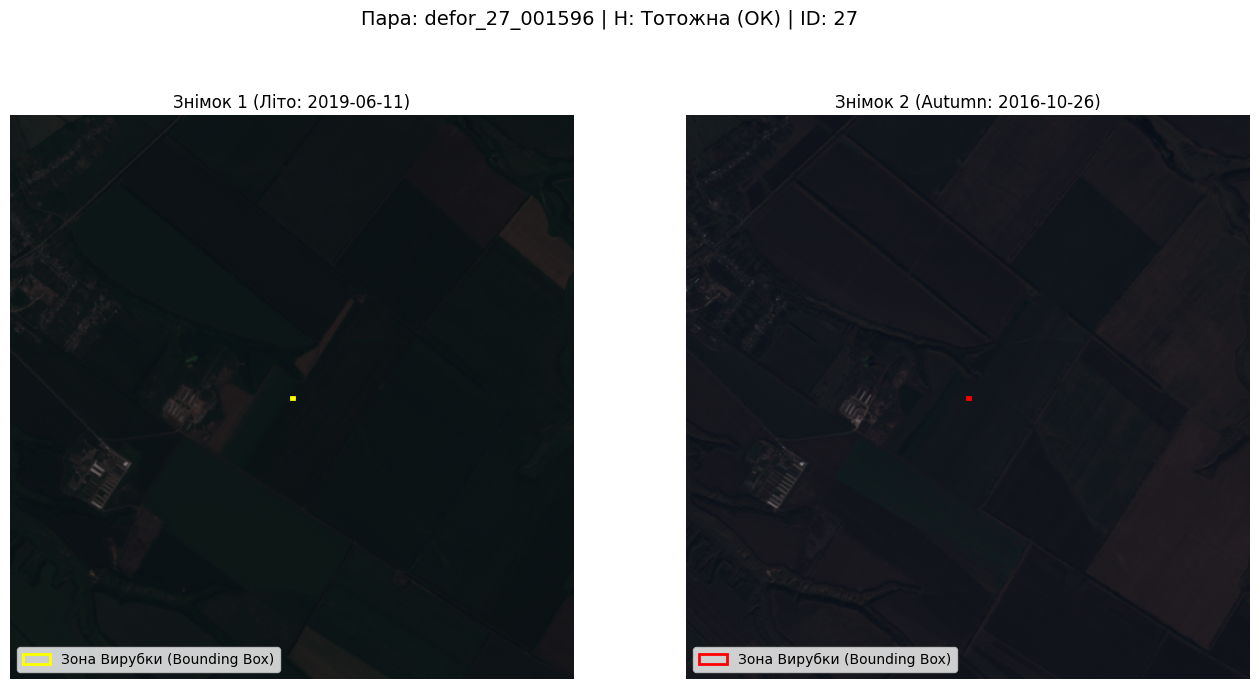


🖼️ Візуалізація: defor_36_002022


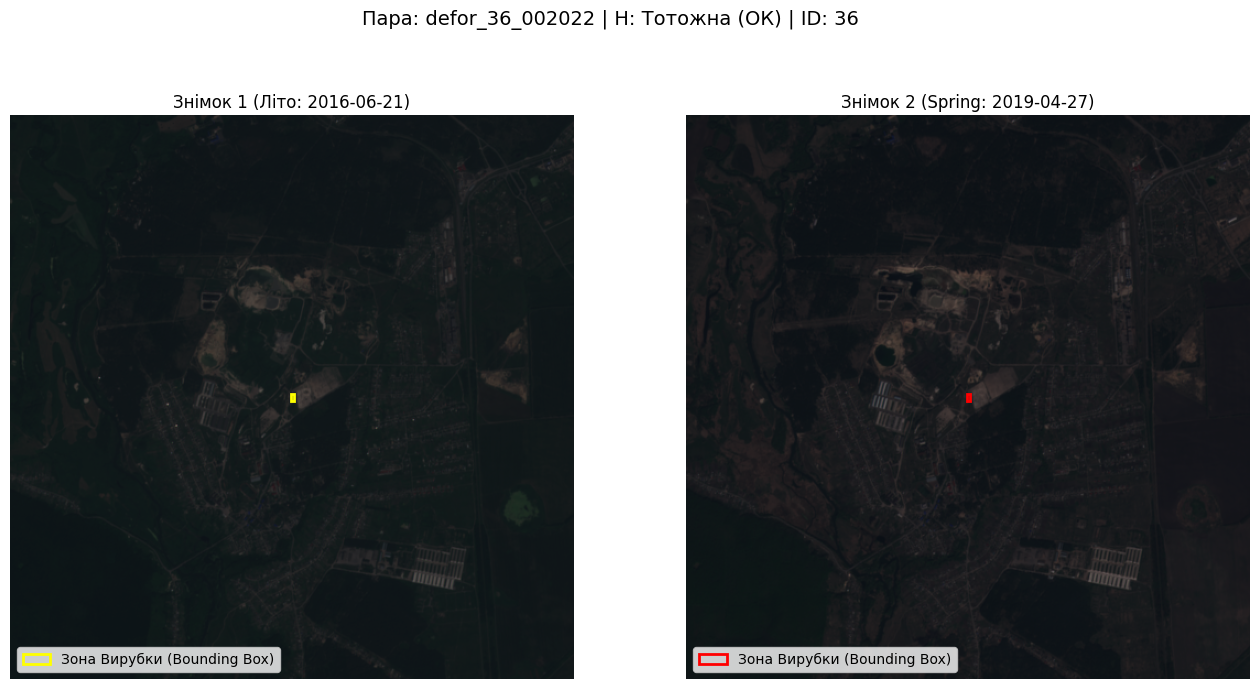


🖼️ Візуалізація: defor_25_001414


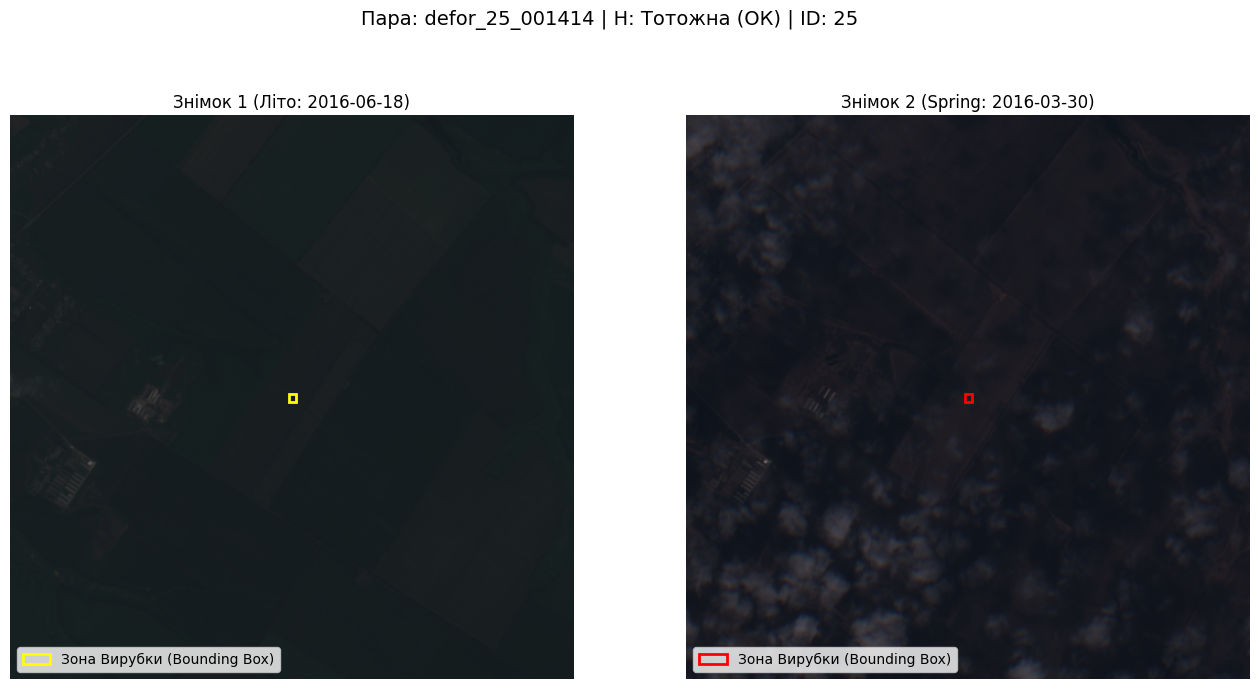

In [13]:
if data_folders_list:
    print("\n--- Демонстрація Візуалізації ---")
    
    sample_folders = np.random.choice(data_folders_list, size=min(3, len(data_folders_list)), replace=False)
    
    for folder in sample_folders:
        visualize_patch_and_deforestation(folder, RGB_INDICES)
else:
    print("⚠️ Не знайдено жодної коректної папки для візуалізації.")